In [144]:
import pandas as pd
import numpy as np
from collections import Counter
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# import nltk
# nltk.download('wordnet')
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpt
mpt.rcParams['figure.figsize'] = (18, 8)
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_parquet('../scraped_data/reviews.parquet.gzip')
df.head()

,title,date,location,rating,text
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     3870 non-null   object        
 1   date      3870 non-null   datetime64[ns]
 2   location  3870 non-null   object        
 3   rating    3870 non-null   float32       
 4   text      3870 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 136.2+ KB


In [11]:
df_ts = df.set_index('date')
df['date'].describe()

count                    3870
unique                    524
top       2019-11-03 00:00:00
freq                       67
first     2018-11-01 00:00:00
last      2020-09-19 00:00:00
Name: date, dtype: object

In [249]:
z = df_ts.resample('W')['rating'].agg(['mean', 'count'])
x = z.index.map(lambda x: str(x)[:10] + ' - ' + str(pd.offsets.DateOffset(6) + x)[:10])
ticks = [
    ['End of Q4 2018', (2019,1,1)], 
    *[[f'End of Q{i+1} 2019', (2019 if i < 3 else 2020, 4+i*3 if i < 3 else 1, 1)] for i in range(4)], 
    *[[f'End of Q{i+1} 2020', (2020, 4+i*3 , 1)] for i in range(2)], 
]

ticktext, tickvals = [], []
for i in ticks:
    idx = np.where(z.index > pd.Timestamp(*i[1]))[0][0] - 1
    ticktext.append(i[0])
    tickvals.append(x[idx])

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=x, 
        y=z['mean'],
        name='Average Rating Score',
        mode='lines',
    ),
    secondary_y=True,
)
fig.add_trace(
    go.Bar(x=x, y=z['count'],name='Ratings Count'),
    secondary_y=False,
)

# Update plot title & legend
fig.update_layout(
    title=dict(text='Product Reviews', x=0.5),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=0.945
    )
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
    rangeslider_visible=True,
)

# Update y-axes titles
fig.update_yaxes(title_text="Ratings Count", secondary_y=False)
fig.update_yaxes(title_text="Average Rating Score", secondary_y=True)
                  
# Show figure
fig.show()

In [234]:
dates = []
ratings_count = []

for date in tqdm(df['date'].unique()):
    dates.append(date)
    ratings = df_ts.loc[date, 'rating']
    if type(ratings)==np.float32:
        ratings = [ratings]
    count = [0, 0, 0, 0]
    for rating in ratings:
        if rating == 5:
            count[3] += 1
        elif rating >= 4:
            count[2] += 1
        elif rating <= 2:
            count[0] += 1
        else:
            count[1] += 1
    ratings_count.append(count)

y = ['Bad', 'Neutral', 'Good', 'Perfect']
df_ratings = pd.DataFrame(ratings_count, dates, columns = y).resample('W').sum().reset_index()
df_ratings.columns = ['period', *y]
df_ratings['period'] = x
df_ratings.head()

,period,Bad,Neutral,Good,Perfect
0,2018-11-04 - 2018-11-10,0,0,0,1
1,2018-11-11 - 2018-11-17,0,0,0,0
2,2018-11-18 - 2018-11-24,1,0,0,1
3,2018-11-25 - 2018-12-01,1,1,0,0
4,2018-12-02 - 2018-12-08,1,0,0,3


In [248]:
fig = px.bar(df_ratings, x='period', y=y)

# Update plot title, legend, and barmode
fig.update_layout(
    title=dict(text='Product Reviews', x=0.5),
    legend=dict(
        title_text="Review Category",
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="right",
        x=1.0
    ),
    barmode='stack'
)

# Update x-axis
fig.update_xaxes(
    title_text="Time",
    ticktext=ticktext,
    tickvals=tickvals,
    tickangle=-90,
    rangeslider_visible=True,
)

fig.show()

In [128]:
fig = px.histogram(df, 'rating', marginal='box')

fig.show()

In [129]:
df['location'].value_counts()

India    3870
Name: location, dtype: int64

In [200]:
fig = px.histogram(df['text'].apply(lambda x: len(x.split())), 'text', marginal = 'box')
fig.show()

In [202]:
fig = px.histogram(df['text'].apply(lambda x: np.clip(len(x.split()), 0, 50)), 'text', marginal = 'box')
fig.show()

In [207]:
fig = px.histogram(df['title'].apply(lambda x: len(x.split())), 'title', marginal = 'box')
fig.show()

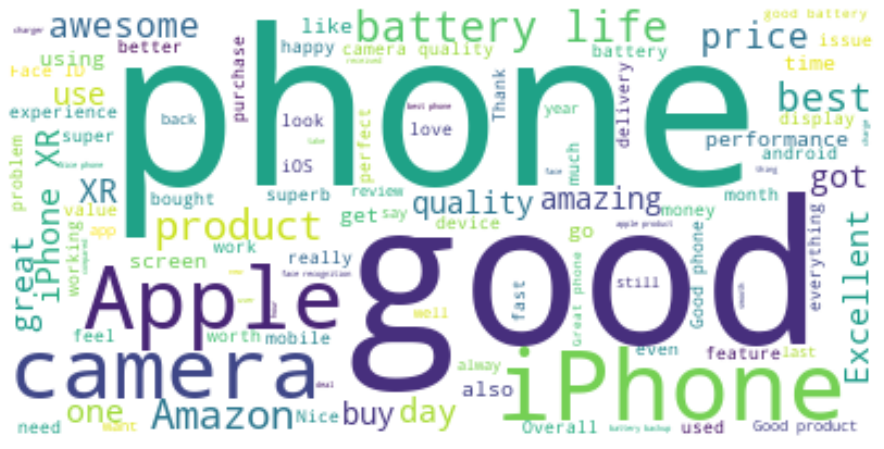

In [156]:
stop = set(stopwords.words('english'))

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

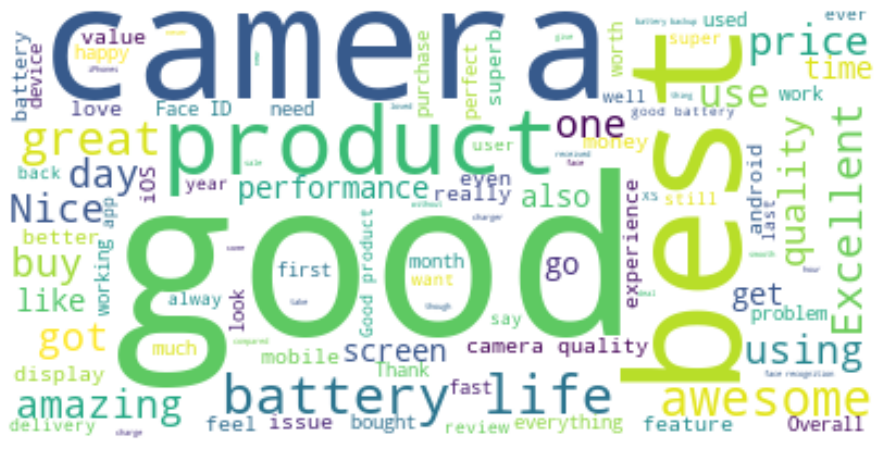

In [160]:
stop = set(stopwords.words('english'))
new_stopwords = ['amazon', 'phone', 'xr', 'iphone', 'apple']
for word in new_stopwords:
    stop.add(word)

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['text'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

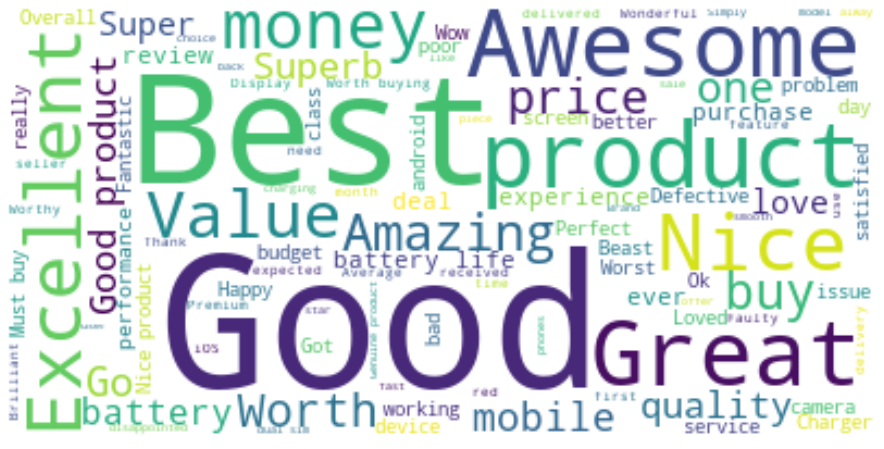

In [161]:
# stop = set(stopwords.words('english'))

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stop
).generate('\n'.join(list(df['title'])))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [162]:
# stop = set(stopwords.words('english'))

text_word_counter = Counter()
title_word_counter = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text', 'title']]
    text = text.lower()
    title = title.lower()
    for word in text.split():
        if word not in stop:
            text_word_counter[word] += 1
    for word in title.split():
        if word not in stop:
            title_word_counter[word] += 1

In [178]:
z = text_word_counter.most_common()
n = 50
x = [i[0] for i in z][:n]
y = [i[1] for i in z][:n]

fig = go.Figure(
    data=[go.Bar(x=x, y=y)],
    layout=dict(
        title=dict(text='Text Word Frequency', x=0.5),
        xaxis=dict(title_text='Word'),
        yaxis=dict(title_text='Frequency'),
    ),
)

fig.show()

In [177]:
z = title_word_counter.most_common()
n = 50
x = [i[0] for i in z][:n]
y = [i[1] for i in z][:n]

fig = go.Figure(
    data=[go.Bar(x=x, y=y)],
    layout=dict(
        title=dict(text='Title Word Frequency', x=0.5),
        xaxis=dict(title_text='Word'),
        yaxis=dict(title_text='Frequency'),
    ),
)

fig.show()

In [186]:
# stop = set(stopwords.words('english'))
punc = set(string.punctuation)
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def stem_and_lemma(word):
    return stemmer.stem(lemma.lemmatize(word, pos='v'))

def clean(doc):
    # remove punctuations
    for ch in punc:
        doc = doc.replace(ch, ' ')
    # text to lower case text
    low_case_doc = [i for i in doc.lower().split()]
    # remove stopwords
    stopwords_punc_free = " ".join([i for i in low_case_doc if i not in stop])
    # stem and lemmatize text
    normalized = " ".join(stem_and_lemma(word.strip()) for word in stopwords_punc_free.split())
    return normalized

text_clean = [clean(doc) for doc in tqdm(df['text'])]
title_clean = [clean(doc) for doc in tqdm(df['title'])]

df['title_clean'] = title_clean
df['text_clean'] = text_clean

df.head()

,title,date,location,rating,text,title_clean,text_clean
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...,purchas 8 x xs,note detail comparison 8 x xs use month also s...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....,buy,bad experi back camera find defect non functio...
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...,happi purchas,amaz amaz camera come 7 plus great servic
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...,authoris resel pleas take note,get today product look amaz unfortun face id w...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...,excel batteri life butteri smooth ui,android user life decid tri io love camera bat...


In [187]:
text_word_counter = Counter()
title_word_counter = Counter()

for idx in tqdm(df.index):
    text, title = df.loc[idx, ['text_clean', 'title_clean']]
    for word in text.split():
        text_word_counter[word] += 1
    for word in title.split():
        title_word_counter[word] += 1